In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# mathematical helpers
from scipy.linalg import expm
from scipy.integrate import cumtrapz, trapz

In [3]:
np.random.seed(42)

## Experiment data

In the following we generate some experiment data to test our Kalman filter on.

In [4]:
N = 1000

We note the "true" signals as `*_gt` (ground-truth).

In [5]:
t = np.linspace(0, 50, N) # 0 - 50s

In [6]:
dt = t[1]-t[0]

In [7]:
a_gt = np.zeros_like(t)

In [8]:
def fill_value(target, start, end, value):
    t_mask = (t >= start) & (t < end)
    target[t_mask] = value

In [9]:
fill_value(a_gt, 3, 8, -10)
fill_value(a_gt, 14, 18, 10)
fill_value(a_gt, 27, 28, 10)
fill_value(a_gt, 37, 38, 10)

In [10]:
v0 = -10
v_gt = cumtrapz(a_gt, t, dx=dt, initial = 0) + v0

In [11]:
h0 = 1000
h_gt = cumtrapz(v_gt, t, dx=dt, initial = 0) + h0

In [12]:
a_meas = a_gt + np.random.randn(N)*0.5

In [13]:
h_meas = h_gt + np.random.randn(N)*10

Text(0.5, 0.98, 'Measurement data')

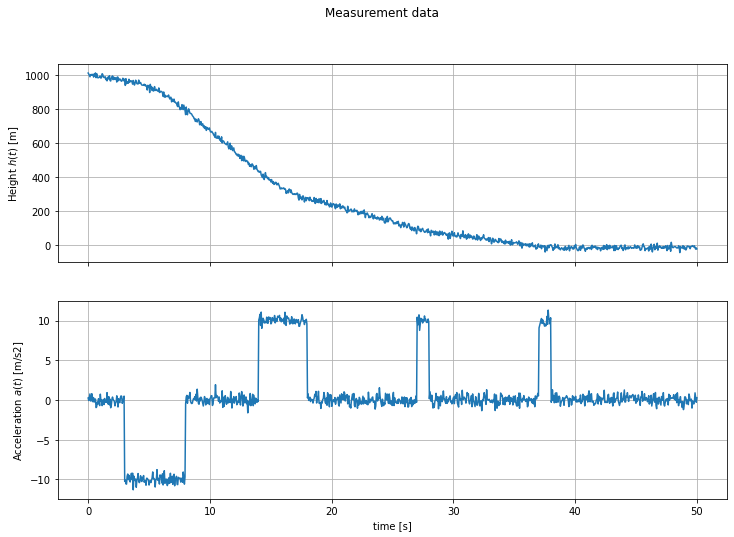

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
ax[0].plot(t, h_meas)
#ax[0].set_ylim([-1, 1000])
ax[0].set_ylabel("Height $h(t)$ [m]")
ax[0].grid()

ax[1].plot(t, a_meas)
ax[1].set_ylabel("Acceleration $a(t)$ [m/s2]")
ax[1].grid()

ax[-1].set_xlabel("time [s]");

fig.suptitle("Measurement data")

## State space model

In the following we have the continuous representation of our state-space model.

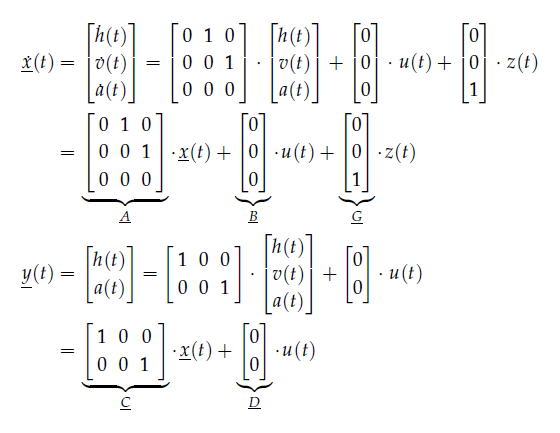

Possible changes in $a(t)$ are modelled as system noise $z(t)$:

In [15]:
A = np.array([[0, 1, 0],
              [0, 0, 1],
              [0, 0, 0]])

B = np.array([[0, 0, 0]]).T # transpose from row to col vec

G = np.array([[0, 0, 1]]).T

C = np.array([[1, 0, 0],
              [0, 0, 1]])

D = np.array([[0, 0]]).T

## Discrete representation

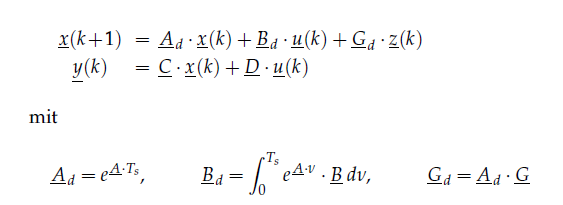

In [16]:
Ad = expm(A*dt)
Gd = Ad@G

# only in this example, calculated analytically!
Bd = np.zeros_like(B)

In [41]:
print("Ad =")
print(Ad)
print()
print("Bd =")
print(Bd)
print()
print("Gd =")
print(Gd)
print()

Ad =
[[1.         0.05005005 0.0012525 ]
 [0.         1.         0.05005005]
 [0.         0.         1.        ]]

Bd =
[[0]
 [0]
 [0]]

Gd =
[[0.0012525 ]
 [0.05005005]
 [1.        ]]



## Noise estimation

Before we can implement the calman filter equations, we need to quantify the noise introduced by $z_k$ and $v_k$.

### Process noise

For this example we modelled the change in $a$ as noise. We know, that the change in acceleration is below $10 m/s^2$ in $99\% = 3\sigma$ of all cases.

\begin{equation}
\sigma_z = \frac{10 m/s^2}{3}\\
\sigma^2_z = \frac{100 m^2/s^4}{9}
\end{equation}

Alternatively we ca write:

\begin{equation}
z \sim N(0, \sigma^2_z) = N(0, Q)
\end{equation}

In our example $Q$ is 1x1 matrix.

In [18]:
Q = [[100/9]]

### Measurement noise

We can estimate the measurement noise by taking "steady state" samples.

In [19]:
def get_samples_from_time_period(x, start, end):
    t_mask = (t >= start) & (t < end)
    return x[t_mask]

Height measurement:

In [20]:
height_samples = get_samples_from_time_period(h_meas, 40, 50)

In [21]:
sigma_h = height_samples.std()
print(sigma_h)

9.84527278948709


Acceleration measurement:

In [22]:
accel_samples = get_samples_from_time_period(a_meas, 40, 50)

In [23]:
sigma_a = accel_samples.std()
print(sigma_a)

0.47770576075147597


Measurement noise matrix $R$:

In [24]:
R = np.array([[sigma_h**2, 0],
              [0, sigma_a**2]])
print(R)

[[96.9293963   0.        ]
 [ 0.          0.22820279]]


$R$ defines the "level of confidence in the measurements.

## Kalman filter implementation

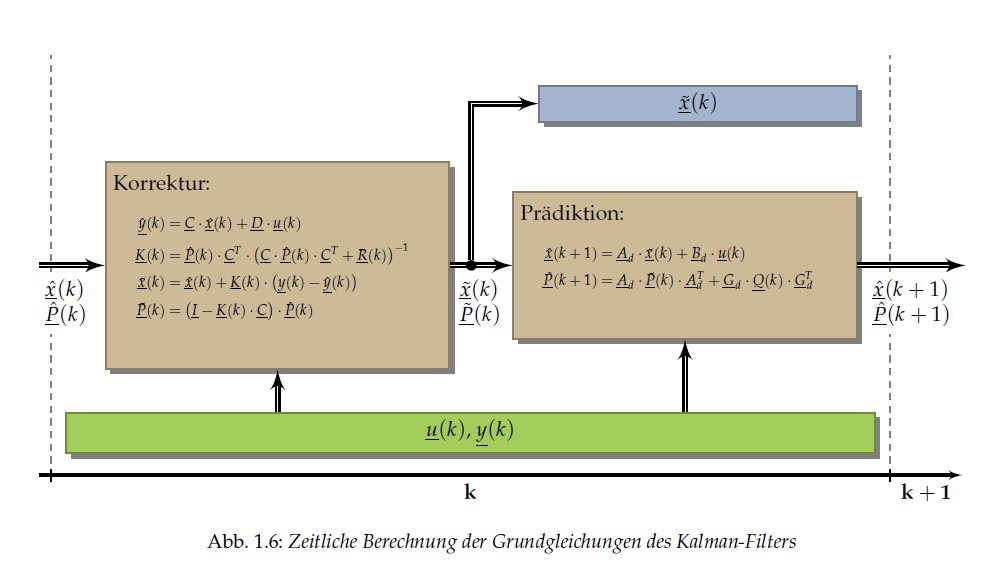

First define our initial assumptions (prediction) for state $\mathbf{x}$:

In [25]:
h0 = 1000
v0 = 0 # let's take some "wrong" assumption
a0 = 0

In [26]:
x_pred = np.asarray([[h0, v0, a0]]).T
print(x_pred)

[[1000]
 [   0]
 [   0]]


Initial confidence in our prediction (matrix $\mathbf{P}$)

In [27]:
sigma_h_pred = 100
sigma_v_pred = 10
sigma_a_pred = 10

In [28]:
P_pred = np.zeros((3, 3))
P_pred[0, 0] = sigma_h_pred**2
P_pred[1, 1] = sigma_v_pred**2
P_pred[2, 2] = sigma_a_pred**2
print(P_pred)

[[10000.     0.     0.]
 [    0.   100.     0.]
 [    0.     0.   100.]]


Let's define both update (*Korrektur*) and prediction (*Prädiktion*) steps.

> We will assume, that $R$, $Q$ do not change over time!

### Prediction Step

The prediction step takes the estimated state $\mathbf{\tilde{x}}_k$ and its confidence $\mathbf{\tilde{P}}_k$ matrix (both are outputs of Kalman filter) and the input vector $\mathbf{u}_k$.

In [29]:
def predict_step(x_estimated, P_estimated, input_vec):
    x_pred = Ad@x_estimated + Bd@input_vec
    P_pred = Ad@P_estimated@Ad.T + Gd@Q@Gd.T
    return x_pred, P_pred

### Update Step

The update step takes the prediction from previous step $\mathbf{\hat{x}}_{k-1}$, confidence $\mathbf{\hat{P}}_{k-1}$ matrix and the measurement vector $\mathbf{y}_{k}$ to correct the prediction.

The balance of the correction between both the prediction and measurement is the Kalman gain $\mathbf{K}_{k}$. It chosen by the idea to minimize the uncertainty $\mathbf{\tilde{P}}_k$.

In [30]:
def update_step(x_pred, P_pred, meas_vec, input_vec):
    K = P_pred@C.T@np.linalg.inv(C@P_pred@C.T + R)
    x_estimated = x_pred+K@(meas_vec-C@x_pred-D@input_vec)
    P_estimated = (np.eye(3)-K@C)@P_pred
    return x_estimated, P_estimated

Input vector $\mathbf{u} = \mathbf{u}(t) = \mathbf{0}$ is always the same for all timesteps.

In [31]:
u = np.asarray([[0]])

In [32]:
# matrices to save the results
x_filtered_tape = np.zeros((N, 3, 1))
P_filtered_tape = np.zeros((N, 3, 3))

for i in range(N):
    
    # construct measurement vector y
    y_meas = np.asarray([[h_meas[i], a_meas[i]]]).T
    
    # update step
    x_estimated, P_estimated = update_step(x_pred, P_pred, y_meas, u)
    
    # prediction step
    x_pred, P_pred = predict_step(x_estimated, P_estimated, u)
    
    # record values for plotting
    x_filtered_tape[i, :] = x_estimated
    P_filtered_tape[i, :] = P_estimated

## Results

First we extract the Kalman filter estimations and the corresponding confidence values.

In [33]:
h_estimated = x_filtered_tape[:, 0, 0]
h_sigma_estimated = np.sqrt(P_filtered_tape[:, 0, 0])

v_estimated = x_filtered_tape[:, 1, 0]
v_sigma_estimated = np.sqrt(P_filtered_tape[:, 1, 1])

a_estimated = x_filtered_tape[:, 2, 0]
a_sigma_estimated = np.sqrt(P_filtered_tape[:, 2, 2])

In [37]:
assert h_estimated.size == N

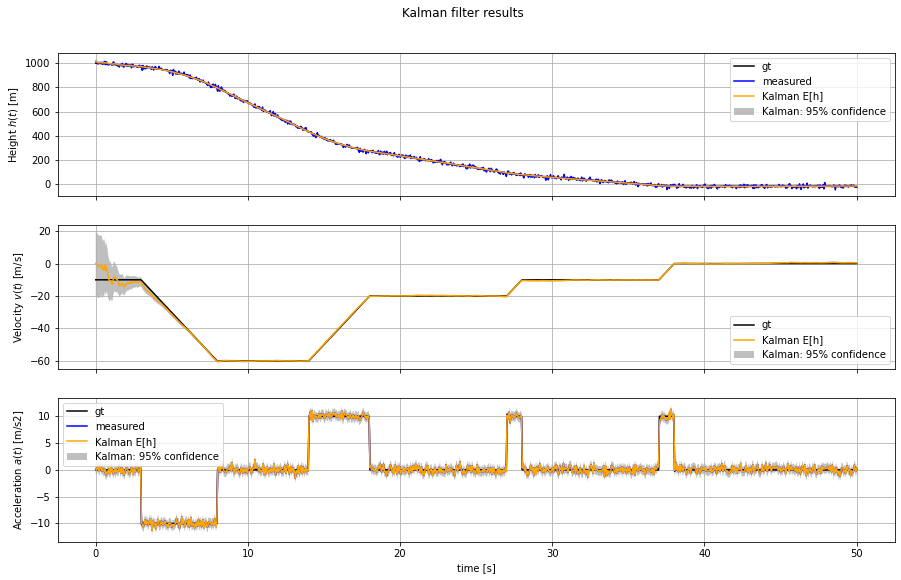

In [38]:
fig, ax = plt.subplots(nrows=3, figsize=(15, 9), sharex=True, facecolor="w")

# shadow code here: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
ax[0].fill(np.concatenate([t, t[::-1]]),
         np.concatenate([h_estimated - 1.9600 * h_sigma_estimated,
                        (h_estimated + 1.9600 * h_sigma_estimated)[::-1]]),
         alpha=.5, fc='grey', ec='None', label='Kalman: 95% confidence')
ax[0].plot(t, h_gt, label="gt", color="k")
ax[0].plot(t, h_meas, label="measured", color="b")
ax[0].plot(t, h_estimated, label="Kalman E[h]", color="orange")
ax[0].set_ylabel("Height $h(t)$ [m]")
ax[0].grid()
ax[0].legend()

ax[1].fill(np.concatenate([t, t[::-1]]),
         np.concatenate([v_estimated - 1.9600 * v_sigma_estimated,
                        (v_estimated + 1.9600 * v_sigma_estimated)[::-1]]),
         alpha=.5, fc='grey', ec='None', label='Kalman: 95% confidence')
ax[1].plot(t, v_gt, label="gt", color="k")
ax[1].plot(t, v_estimated, label="Kalman E[h]", color="orange")
ax[1].set_ylabel("Velocity $v(t)$ [m/s]")
ax[1].grid()
ax[1].legend()


ax[2].fill(np.concatenate([t, t[::-1]]),
         np.concatenate([a_estimated - 1.9600 * a_sigma_estimated,
                        (a_estimated + 1.9600 * a_sigma_estimated)[::-1]]),
         alpha=.5, fc='grey', ec='None', label='Kalman: 95% confidence')
ax[2].plot(t, a_gt, label="gt", color="k")
ax[2].plot(t, a_meas, label="measured", color="b")
ax[2].plot(t, a_estimated, label="Kalman E[h]", color="orange")
ax[2].set_ylabel("Acceleration $a(t)$ [m/s2]")
ax[2].grid()
ax[2].legend()

ax[-1].set_xlabel("time [s]");

fig.suptitle("Kalman filter results", y=0.95);